<a href="https://colab.research.google.com/github/yeqinghuang516/Auto-Drive/blob/master/ML_Image_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
!unzip data.zip

In [0]:
!pip install mahotas

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2
# import mahotas as mt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

import csv
import torch
import torch.utils.data as data
import pandas as pd
from tqdm import tqdm

In [0]:
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)
        
# train_len = int(0.8*len(samples))
# valid_len = len(samples) - train_len
# train_samples, validation_samples = data.random_split(samples, lengths=[train_len, valid_len])

In [0]:
class Dataset(data.Dataset):

    def __init__(self, samples, transform=None):

        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
      
        batch_samples = self.samples[index]
        
        steering_angle = float(batch_samples[3])


        left_img = cv2.imread('data/IMG/' + batch_samples[0].split('/')[-1])
        # left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        left_img = left_img[65:-25, :, :]
        center_img = cv2.imread('data/IMG/' + batch_samples[1].split('/')[-1])
        # center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
        center_img = center_img[65:-25, :, :]
        right_img = cv2.imread('data/IMG/' + batch_samples[2].split('/')[-1])
        # right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
        right_img = right_img[65:-25, :, :]
        
        steering_angle_center = steering_angle
        steering_angle_left = steering_angle + 0.2
        steering_angle_right = steering_angle - 0.2

        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)
      
    def __len__(self):
        return len(self.samples)
      

In [0]:
def extract_harr_feature(img, feature_type, feature_coord=None):
  """Extract the haar feature for the current image"""
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.resize(img, (25, 25))
  ii = integral_image(img)
  return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                            feature_type=feature_type,
                            feature_coord=feature_coord)
    

def extract_haralick_feature(img):
  # calculate haralick texture features for 4 types of adjacency
  textures = mt.features.haralick(img)

  # take the mean of it and return it
  ht_mean = textures.mean(axis=0)
  return ht_mean

In [0]:
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
# X = delayed(extract_feature_image(img, feature_types) for img in images)
dataset = Dataset(samples)
df = pd.DataFrame()
for i in range(len(dataset)):
  datas = dataset[i]
  for data in datas:
    img = data[0]
    angle = data[1]
    # features = extract_harr_feature(img, feature_type=feature_types)
    features = extract_haralick_feature(img)
    line = pd.DataFrame(features.reshape(1, -1))
    line['angle'] = angle
    df = df.append(line)

In [0]:
df.to_csv('ML_haralick.csv')

## Thresholding Based Feature Extraction

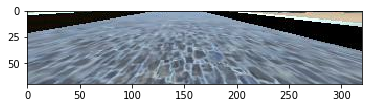

In [5]:
dataset = Dataset(samples)
center, _, _ = dataset[100]
img = center[0]
plt.imshow(img)

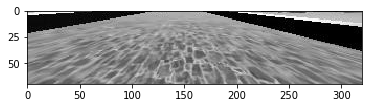

In [0]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')

In [0]:
img.shape

(70, 320, 3)

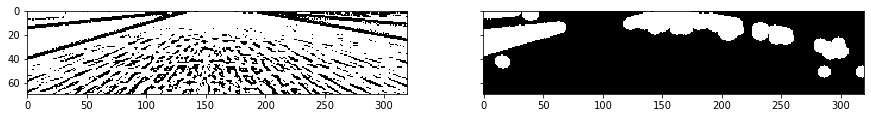

In [0]:
grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# grayImg = cv2.GaussianBlur(grayImg, (3, 3), 0)
threImg = cv2.adaptiveThreshold(grayImg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,11)
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
opening = cv2.morphologyEx(threImg, cv2.MORPH_OPEN, kernel)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(threImg, cmap='gray')
ax2.imshow(opening, cmap='gray')

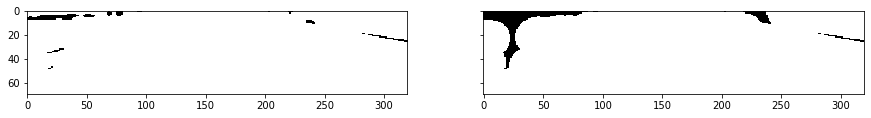

In [0]:
grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
grayImg = cv2.GaussianBlur(grayImg, (9, 9), 0)
threImg = cv2.adaptiveThreshold(grayImg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,31)
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(31,31))
opening = cv2.morphologyEx(threImg, cv2.MORPH_OPEN, kernel)
# closing = cv2.morphologyEx(threImg, cv2.MORPH_CLOSE, np.ones((3,3)))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(threImg, cmap='gray')
ax2.imshow(opening, cmap='gray')

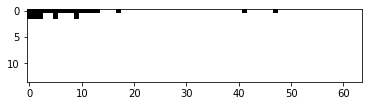

In [0]:
plt.imshow(cv2.resize(opening, (32*2, 7*2)), cmap='gray')

### Watershed Segmentation

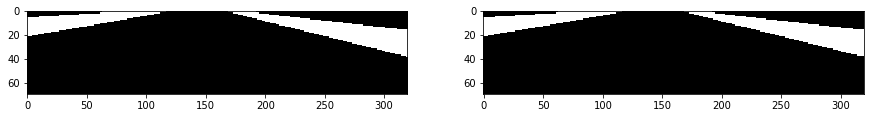

In [0]:
grayImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
grayImg = cv2.GaussianBlur(grayImg, (7, 7), 0)
ret, threImg = cv2.threshold(grayImg,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel =  cv2.getStructuringElement(cv2.MORPH_RECT,(7,3))
opening = cv2.morphologyEx(threImg, cv2.MORPH_OPEN, kernel)
f, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(threImg, cmap='gray')
axes[1].imshow(opening, cmap='gray')

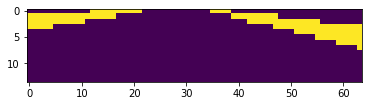

In [0]:
plt.imshow(cv2.resize(opening, (32*2, 7*2)))

In [0]:
def watershed_extraction(img):
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  grayImg = cv2.GaussianBlur(grayImg, (7, 7), 0)
  ret, threImg = cv2.threshold(grayImg,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  kernel =  cv2.getStructuringElement(cv2.MORPH_RECT,(7,3))
  opening = cv2.morphologyEx(threImg, cv2.MORPH_OPEN, kernel)
  # return cv2.resize(opening, (32*2, 7*2))
  return opening

In [0]:
df = pd.DataFrame()
listOfLines = []
for i in tqdm(range(len(dataset))):
  datas = dataset[i]
  for data in datas:
    img = data[0]
    angle = data[1]
    features = watershed_extraction(img)
    line = pd.DataFrame(features.reshape(1, -1))
    line['angle'] = angle
    # df = df.append(line)
    listOfLines.append(line)
  if i % 1000 == 0:
    df = df.append(listOfLines, ignore_index=True)
    listOfLines = []
df = df.append(listOfLines, ignore_index=True)

In [0]:
df.to_csv('ML_segmentation.csv')

In [0]:
!cp ML_segmentation.csv /content/drive/My\ Drive/Autonomous\ Driving/

## Edge Detection Feature Extraction

In [0]:
sobelx = cv2.Sobel(grayImg,cv2.CV_64F,0,1,ksize=5)
sobelx = sobelx - sobelx.min()
sobelx = sobelx / sobelx.max() * 255
sobelx = sobelx.astype('uint8')

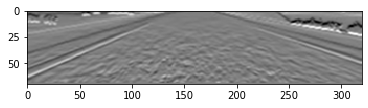

In [0]:
plt.imshow(sobelx, cmap='gray')

In [0]:
sobelx

array([[127, 127, 127, ..., 127, 127, 127],
       [113, 115, 118, ..., 129, 128, 128],
       [ 92,  91,  90, ..., 140, 141, 142],
       ...,
       [120, 123, 126, ..., 121, 115, 112],
       [134, 133, 131, ..., 131, 128, 127],
       [127, 127, 127, ..., 127, 127, 127]], dtype=uint8)

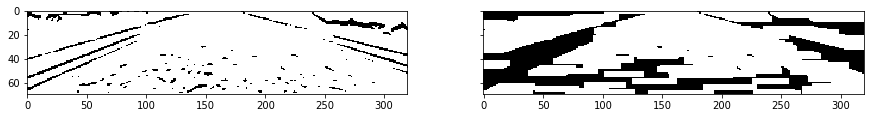

In [0]:
threImg = cv2.adaptiveThreshold(sobelx,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,31,21)
kernel =  cv2.getStructuringElement(cv2.MORPH_RECT,(31,5))
opening = cv2.morphologyEx(threImg, cv2.MORPH_OPEN, kernel)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(threImg, cmap='gray')
ax2.imshow(opening, cmap='gray')

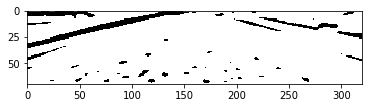

In [0]:
plt.imshow(threImg, cmap='gray')